In [1]:
from ioos_metrics import ioos_metrics

In [2]:
#| code-summary: fetch the latest mbon data
stats_df = ioos_metrics.mbon_stats()

In [3]:
#| code-summary: define streamgraph function
def make_streamgraph(og_df, y_colname, plt_title):
  # subset the df to save RAM
  df_subset = og_df[[y_colname, "literature_published"]]
  # split any pipe-delimited rows in y_colname
  df = df_subset.assign(**{y_colname: df_subset[y_colname].str.split("|")}).explode(y_colname)
  # Convert the 'literature_published' column to datetime
  df["literature_published"] = pd.to_datetime(df["literature_published"])

  # Extract month and year for aggregation
  df["year_month"] = df["literature_published"].dt.to_period("M")

  # Group by year_month and title, then get the cumulative count
  df["count"] = df.groupby(y_colname).cumcount() + 1
  monthly_counts = df.groupby(["year_month", y_colname]).agg({"count": "max"}).reset_index()

  # Pivot the DataFrame to have year_month as rows and titles as columns
  pivot_df = monthly_counts.pivot(index="year_month", columns=y_colname, values="count").fillna(0).cumsum()

  # Plotting the streamgraph
  plt.figure(figsize=(8, 6))
  plt.stackplot(pivot_df.index.to_timestamp(), pivot_df.T, labels=pivot_df.columns)
  plt.title(plt_title)
  plt.xlabel("Date")
  plt.ylabel("Cumulative Count")
  plt.xticks(rotation=45)

C:\Users\Mathew.Biddle\AppData\Local\Temp\1\ipykernel_19888\879801337.py:11: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['literature_published'].dt.to_period('M')


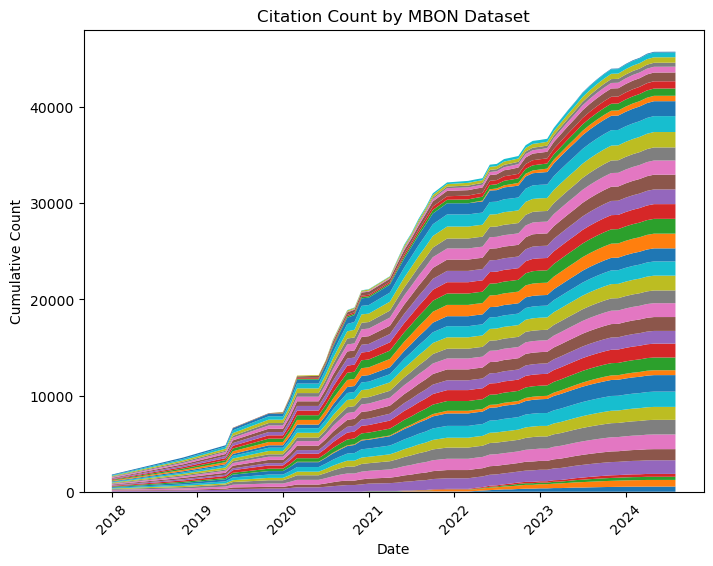

In [4]:
#| code-summary: streamgraph of citations per dataset
import matplotlib.pyplot as plt
import pandas as pd

make_streamgraph(stats_df, "obis_title", "Citation Count by MBON Dataset")
plt.show()

C:\Users\Mathew.Biddle\AppData\Local\Temp\1\ipykernel_19888\879801337.py:11: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['literature_published'].dt.to_period('M')


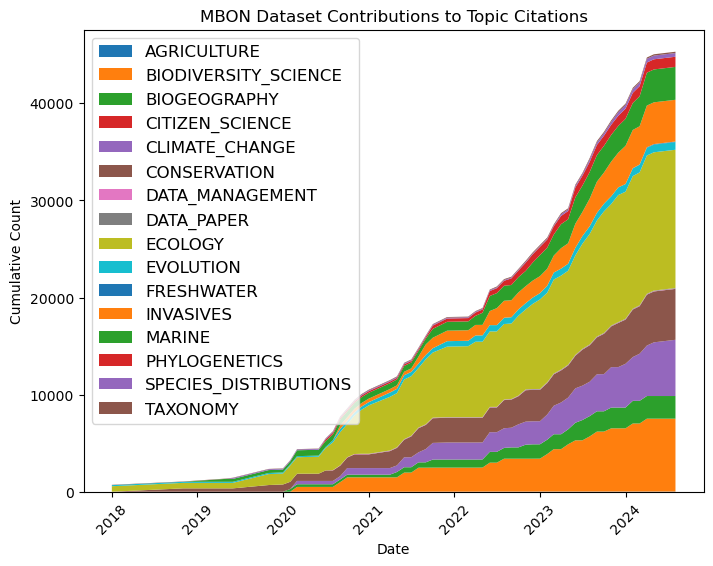

In [5]:
#| code-summary: streamgraph of citations per topic
# split up column with pipe-delimited multi-values

make_streamgraph(stats_df, "literature_topics", "MBON Dataset Contributions to Topic Citations")
plt.legend(loc="upper left",prop={"size": 12})
plt.show()

In [6]:
# import squarify

# df = stats_df

# # Column name that might contain pipe-delimited values
# y_colname = 'literature_topics'

# # Split the pipe-delimited values into individual rows
# df_split = df.assign(**{y_colname: df[y_colname].str.split('|')}).explode(y_colname)

# # Count occurrences of each topic
# topic_counts = df_split[y_colname].value_counts().reset_index()
# topic_counts.columns = ['literature_topics', 'count']

# # Plotting the treemap
# plt.figure(figsize=(12, 8))
# squarify.plot(sizes=topic_counts['count'], label=topic_counts['literature_topics'], alpha=0.8)
# plt.axis('off')
# plt.title('Treemap of Literature Topics')
# plt.show()

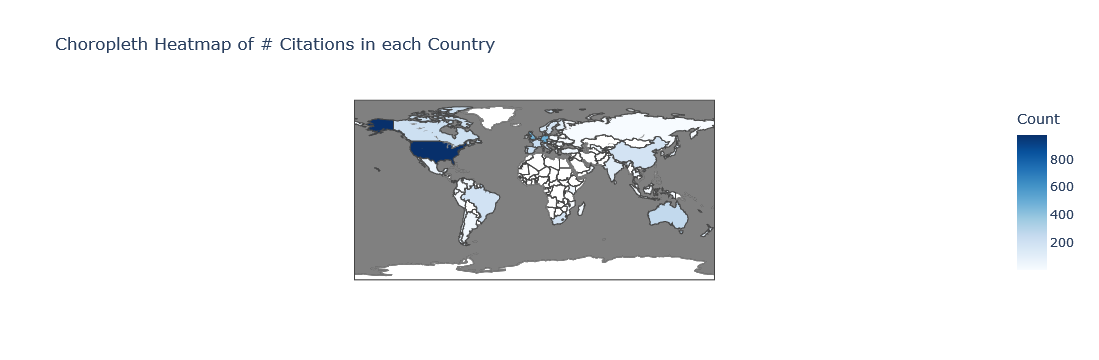

In [7]:
#| code-summary: create chlopleth map
import plotly.express as px

loc_colname = "literature_countries_of_researcher"
og_df = stats_df[[loc_colname]]

# split any pipe-delimited rows in y_colname
df = og_df.assign(**{loc_colname: og_df[loc_colname].str.split("|")}).explode(loc_colname)

# Count the occurrences of each country
country_counts = df[loc_colname].value_counts().reset_index()
country_counts.columns = ["Country", "Count"]

# Create the choropleth map with a monochrome color scale and gray for missing data
fig = px.choropleth(country_counts,
                    locations="Country",
                    locationmode="country names",
                    color="Count",
                    hover_name="Country",
                    color_continuous_scale=px.colors.sequential.Blues,
                    title="Choropleth Heatmap of # Citations in each Country"
  )

# Update layout to set color for missing data
fig.update_geos(
    showcoastlines=True, coastlinecolor="Gray",
    showcountries=True,
    showland=True, landcolor="White",
    showocean=True, oceancolor="Gray",
    showlakes=True, lakecolor="Gray"
)

# Show the plot
fig.show()

In [8]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud


def make_wordcloud(df, colname):
    # Combine all abstracts into a single string
    text = " ".join(abstract for abstract in df[colname])

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")  # Turn off axis
    plt.show()


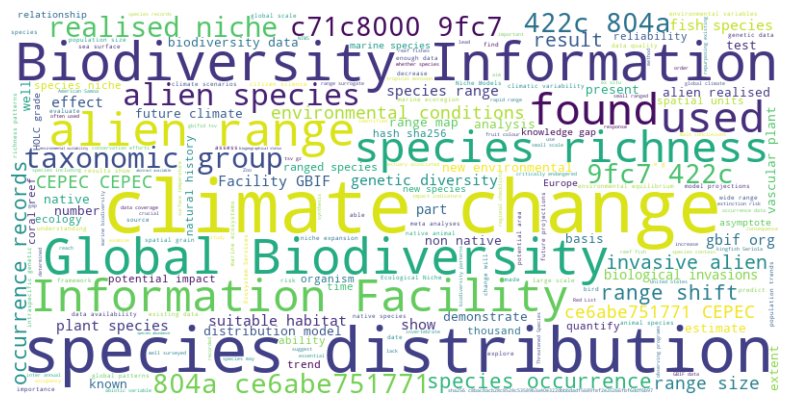

In [9]:
make_wordcloud(stats_df, "literature_abstract")

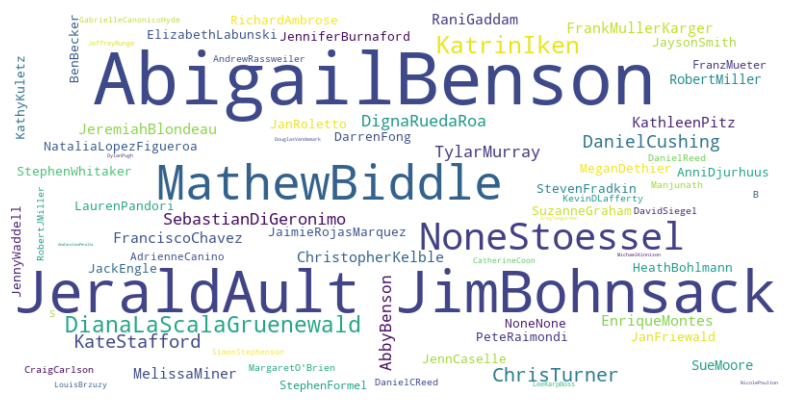

In [10]:
import matplotlib.pyplot as plt

df = stats_df
# Extract givenname and surname from JSON
names = []
for contacts in df["obis_contacts"]:
    contacts_list = contacts
    for contact in contacts_list:
        names.append(f"{contact['givenname']}{contact['surname']}".replace(" ", "").replace("-", "") or "")
#         names.append( or "")

# Combine all names into a single string
text = " ".join(names)
# print(sorted(set(names)))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, collocation_threshold=1e4, background_color="white").generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Turn off axis
plt.show()


# Start working with download statistics

we need to simplify the statistics into a per dataset dataframe

In [11]:
downloads = stats_df.drop_duplicates(subset="obis_id",keep="first")[["obis_downloads","gbif_downloads"]]

## Gather download statistics from the OBIS response

summarize by year

      downloads
year           
2018         27
2019       7312
2020      87692
2021     457248
2022     213969
2023     221396
2024     210662

OBIS: 1198306 downloads


<Axes: xlabel='year'>

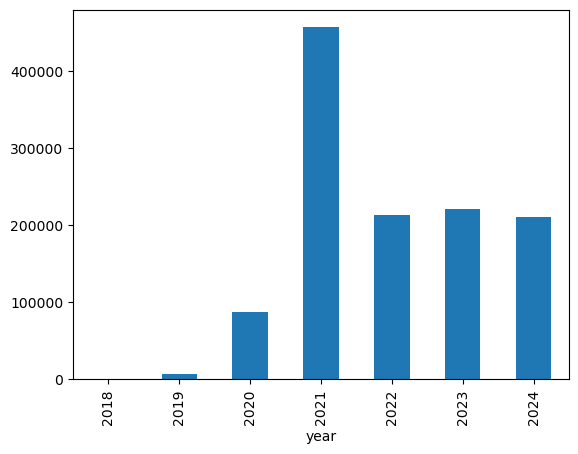

In [12]:
df_obis = pd.DataFrame()
for index, row in downloads[["obis_downloads"]].iterrows():
    df_obis = pd.concat([df_obis, pd.DataFrame(row.iloc[0])])

df_obis.drop(columns="records",inplace=True)
df_obis_yearly_total = df_obis.groupby(by="year").sum()
print(df_obis_yearly_total)
print(f"\nOBIS: {df_obis_yearly_total['downloads'].sum()} downloads")

df_obis_yearly_total["downloads"].plot(kind="bar")

## Gather download statistics from the GBIF response

summarize by year

In [13]:
import ast

df_gbif = pd.DataFrame()

for index, row in downloads[["gbif_downloads"]].iterrows():
    df_gbif = pd.concat([df_gbif, pd.DataFrame(ast.literal_eval(row.iloc[0]))])

df_gbif.index.name = "year"

df_gbif_yearly_total = df_gbif.groupby(by="year").sum()

print(df_gbif_yearly_total)
print(f"\nGBIF: {df_gbif_yearly_total['number_downloads'].sum()} downloads")

      number_downloads
year                  
2016              3369
2017             30080
2018             48361
2019             29966
2020             41590
2021             51336
2022             76654
2023             97296
2024             36033

GBIF: 414685 downloads


# Create a stacked bar chart of number of downloads per year from GBIF and OBIS

Text(0, 0.5, 'Number of Downloads')

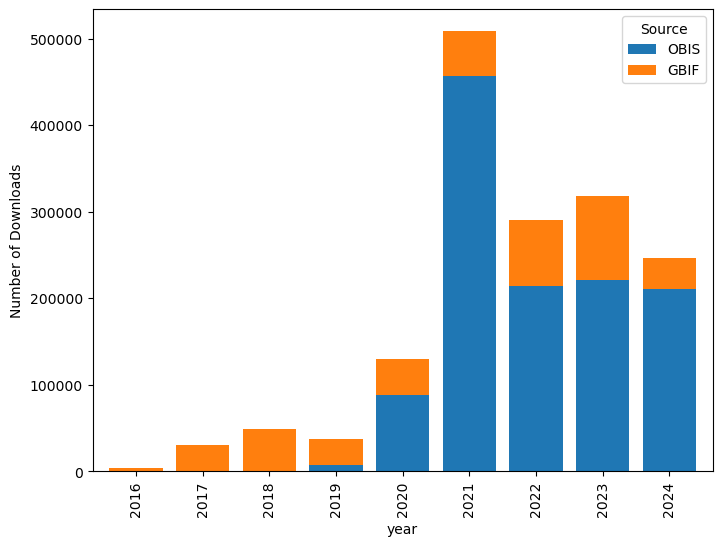

In [14]:
df_join = df_obis_yearly_total.join(df_gbif_yearly_total,how="outer")

df_join.rename(columns={"number_downloads":"GBIF",
                       "downloads":"OBIS"},
               inplace=True)

ax = df_join.plot.bar(stacked=True, width=.8, figsize=(8, 6))
ax.legend(title="Source")
ax.set_ylabel("Number of Downloads")

In [15]:
print(f"{len(stats_df.drop_duplicates(subset='doi',keep='first')[['doi']])} dataset DOI's at GBIF")
print(f"{len(stats_df)} total citations via GBIF")

41 dataset DOI's at GBIF
2428 total citations via GBIF
